# **Trabajo Práctico Final**: "Clasificación de la osteoartritis de rodilla utilizando imágenes de rayos X"
___________________________________________________________________________
##*Visión por Computadora II*                                   
##*Facultad de Ingeniería de la Universidad de Buenos Aires*
##*Laboratorio de Sistemas Embebidos*                                                 
##*Javier Etcheto, Alejandro Le Mehaute y David Canal*
##*Julio 2025*

 # **1. Resumen**
 ---
Se desarrolló un modelo de clasificación de imágenes de rayos X de rodillas, capaz de distinguir entre rodillas sanas y aquellas con osteoartritis.

Previo al entrenamiento del modelo, se realizó un análisis exploratorio de los datos disponibles con el objetivo de comprender su distribución, calidad y características relevantes. Posteriormente, se procedió a implementar los modelos [nombre del modelo 1] y [nombre del modelo 2], evaluando su desempeño en la tarea de clasificación.

# **2. Introducción**
---
La  osteoporosis es una enfermedad metabólica ósea caracterizada por l adisminución de la masa y la calidad del hueso, lo que incrementa la fragilidad ósea y el riesgo de fracturas. La osteopenia, considerada una etapa previa, también implica una reducció de la densidad mineral ósea, pero en menor grado. La detección temprana de estas condiciones es fundamental para implementar estrategias preventivas y terapéuticas que mejoren la calidad de vida de los pacietes.
El diagnóstico convencional de estas patologías se basa principalmente en técnicas como la absorciometría dual X (DXA), considerada el estándar para medir la densidad mineral ósea. Sin embargo, en muchos entornos clínicos los estudios radiográficos convencionales siguen siendo el primer recurso disponible para la evaluación  de articulaciones, incluida la rodilla.
En este contexto, la interpretación de radiográfias de rodilla requiere un alto nivel de experiencia por parte del personal médico, y esta sujeta a variabilidad interobservador. Además, el volumen creciente de imágenes médicas en los sistemas hospitalarios genera la necesidad de herramientas automatizadas que apoyen el diagnóstico y permitan una clasificación más objetiva y eficiente.
Por ello, se propone el desarrollo de un modelo de visión por computadora basado en aprendizaje profundo que sea capaz de clasificar imágenes de tayos X de rodillas en tres categorría:


*   *Normal.* Sin evidencia de pérdida significativa de masa ósea.
*   *Osteopenia.* Disminución moderada de desidad mineral ósea.
*   *Osteoporosis.* Pérdida severa de masa ósea, con riesgo elevado de fractura.






# **3. Analisis Exploratorio de Datos (EDA)**
---
Antes de aplicar técnicas de procesamiento de imágenes y entrenar modelos, es necesario realizar un Análisis Exploratorio de Datos (EDA, por sus siglas en inglés: Exploratory Data Analysis), con el fin de comprender las características principales del sets de imágenes.

En nuestro caso particular, el EDA se llevó a cabo sobre un conjunto de radiografías de rodilla etiquetadas en las tres categorías mencionadas en la sección anterior: *normal, osteopenia y osteoporosis*.

A continuación, se procedió a importar el conjunto de datos y a realizar una visualización inicial del mismo.

## **3.1 Importación y visualización inicial del dataset**
---

In [ ]:
#!pip install -q kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fuyadhasanbhoyan/knee-osteoarthritis-classification-224224")

print("Path to dataset files:", path)

100%|██████████| 32.7M/32.7M [00:00<00:00, 132MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fuyadhasanbhoyan/knee-osteoarthritis-classification-224224/versions/1


In [ ]:
from pathlib import Path
import os

exts = set(p.suffix for p in Path(path).rglob("*") if p.is_file())
print(f"El dataset contiene imagenes con extensiones {' '.join(exts)}")

El dataset contiene imagenes con extensiones .png .JPEG .jpeg .jpg


In [ ]:
from PIL import Image # Asegúrate de importar Image
from pathlib import Path
import os

clases = ['Normal', 'Osteopenia', 'Osteoporosis']
modos = set()
total_imagen = 0

for clase in clases:
    img_path = f"{path}/Knee Osteoarthritis Classification/train/{clase}"
    total_imagen += len([f for f in os.listdir(img_path) if os.path.isfile(f"{img_path}/{f}")])
    for img_name in os.listdir(img_path):
        try:
            img = Image.open(f"{img_path}/{img_name}")
            modos.add(img.mode)
        except Exception as e:
            print(f"Error con {img_name}: {e}")

print(f"Modos encontrados {' y '.join(modos)}")
print(f"El dataset contiene {total_imagen} imagenes")

Modos encontrados L y RGB
El dataset contiene 3780 imagenes


El conjunto de datos está compuesto por 3780 imágenes en formatos PNG y JPG, en modos de color L (escala de grises) y RGB.

Con el objetivo de entrenar un modelo de clasificación, el dataset fue dividido en dos subconjuntos: uno para entrenamiento (training dataset) y otro para validación (validation dataset).

Posteriormente, se realizó una visualización inicial de cinco imágenes representativas de cada categoría dentro del conjunto de entrenamiento, con el fin de verificar la calidad y diversidad de los datos

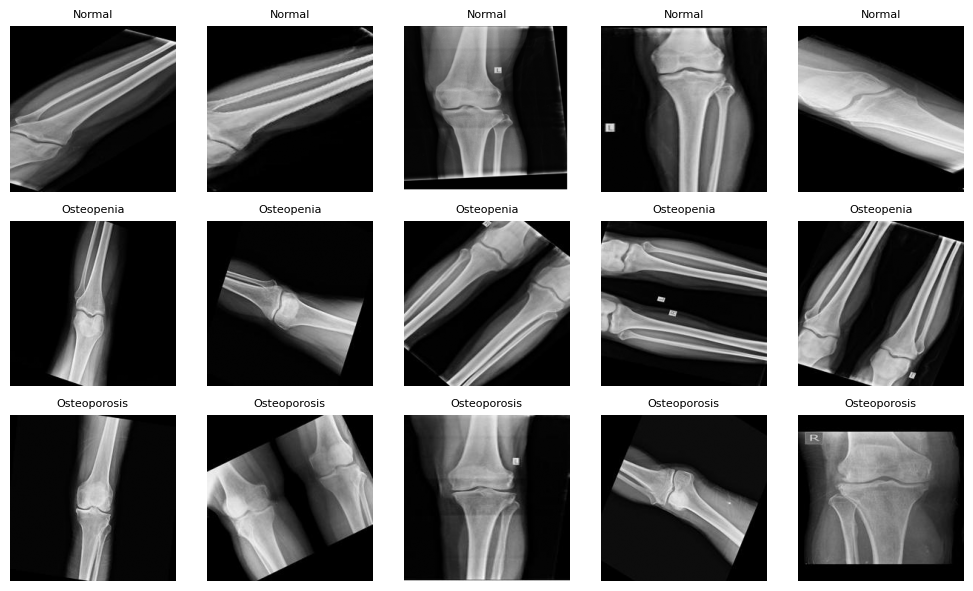

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import random

# Visualizo 5 imágenes por clase en una grilla 3x5 para tener una idea general del dataset
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))

for i, clase in enumerate(clases):
    dir_clase = f"{path}/Knee Osteoarthritis Classification/train/{clase}"
    imgs = random.sample(os.listdir(dir_clase), 5)  # 5 imágenes aleatorias
    for j in range(5):
        img = Image.open(f"{dir_clase}/{imgs[j]}").convert('L')
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(f"{clase}", fontsize=8)

plt.tight_layout()
plt.show()


Tal como se muestra en la figura anterior, se presentan cinco ejemplos representativos clasificados en tres categorías: Normal, Osteopenia y Osteoporosis. Todas las imágenes están en escala de grises, lo cual es característico de las radiografías. Se observa una considerable variabilidad en la orientación (proyección lateral y anteroposterior) y en el tamaño aparente de las estructuras óseas, lo que resalta la necesidad de aplicar un preprocesamiento consistente.

Desde el punto de vista clínico, las imágenes normales exhiben un mayor contraste y una definición trabecular más marcada (es decir, en el interior del hueso). En los casos de osteopenia, se aprecia una disminución ósea leve a moderada, caracterizada por zonas más opacas debido a la menor refracción de los rayos X en esas áreas. En la osteoporosis, la pérdida de densidad ósea es más pronunciada, lo que da lugar a huesos más transparentes.

Asimismo, se detectan diferencias en la exposición radiográfica y posibles rotaciones en algunas imágenes, lo que refuerza la importancia de aplicar técnicas de normalización de intensidades y estrategias de aumento de datos (data augmentation) para mejorar la robustez del modelo.

## **3.2 Distribución de clases**
---
Contar con un conjunto de datos balanceado es fundamental para evitar que el modelo tienda a sesgarse hacia la clase mayoritaria. Por ello, se procedió a verificar que cada clase contara con un número de imágenes representativo y comparable. El resultado de esta verificación se detalla a continuación:

In [ ]:
for clase in clases:
    img_path = f"{path}/Knee Osteoarthritis Classification/train/{clase}"
    cantidad = len([f for f in os.listdir(img_path) if os.path.isfile(f"{img_path}/{f}")])
    print(f"{clase}: {cantidad} imágenes")

Normal: 1260 imágenes
Osteopenia: 1260 imágenes
Osteoporosis: 1260 imágenes


De las 3780 radiografías disponibles, las mismas se distribuyen equitativamente entre las tres clases planteadas, esdecir en 1260 imagenes por clases, lo cuál indica que a priori el dataset se encuentra ya balanceado.

Analizo tamaño de las imágenes.

In [ ]:
img_size = set()

for clase in clases:
    img_path = f"{path}/Knee Osteoarthritis Classification/train/{clase}"
    for img_name in os.listdir(img_path):
        try:
            img = Image.open(f"{img_path}/{img_name}")
            img_size.add(img.size)  # (ancho, alto)
        except Exception as e:
            print(f"Error con {img_name}: {e}")

print("Tamaños únicos encontrados:", img_size)

Tamaños únicos encontrados: {(224, 224)}


Hago un hashing para detectar imagenes duplicadas.

In [ ]:
!pip install -q imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 5.0 MB/s eta 0:00:00


Veo si las imagenes con el mismo hash son efectivamente iguales.

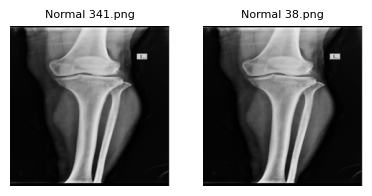

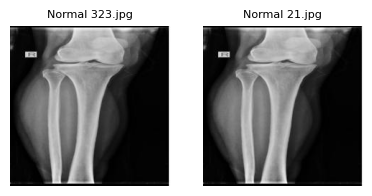

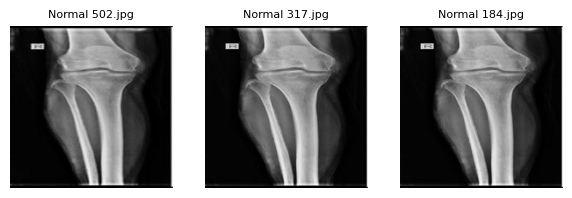

In [ ]:
from collections import defaultdict
import imagehash # Importar imagehash
from PIL import Image
import os
import matplotlib.pyplot as plt


# Agrupo imágenes por hash
hash_dict = defaultdict(list)

for clase in clases:
    dir_clase = f"{path}/Knee Osteoarthritis Classification/train/{clase}"
    for img_name in os.listdir(dir_clase):
        try:
            img_path = f"{dir_clase}/{img_name}"
            img = Image.open(img_path).convert('L')
            h = imagehash.phash(img)
            hash_dict[h].append(img_path)
        except Exception as e:
            print(f"Error con {img_name}: {e}")

# Filtro los hashes con más de una imagen (posibles duplicados)
hashes_duplicados = [imgs for imgs in hash_dict.values() if len(imgs) > 1]

# Muestro algunas imagenes repetidas (limitado a los primeros 3 grupos)
# Ya probé con más de 3 grupos y se ve que son siempre iguales
for grupo in hashes_duplicados[:3]:
    fig, axs = plt.subplots(1, len(grupo), figsize=(2 * len(grupo), 2))
    for i, img_path in enumerate(grupo):
        img = Image.open(img_path)
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(os.path.basename(img_path), fontsize=8)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

Las imágenes con mismos hassh son iguales (al menos a simple vista).

Creo lista para guardar imágenes únicas.

In [ ]:
from collections import Counter # Importar Counter
import imagehash # Importar imagehash
from PIL import Image
import os

imagenes_unicas = []
hashes_vistos = set()

def obtener_imagenes_unicas(path_base, clases, subcarpeta='train'):
    imagenes_unicas = []
    hashes_vistos = set()

    for clase in clases:
        dir_clase = f"{path_base}/Knee Osteoarthritis Classification/{subcarpeta}/{clase}"
        for img_name in os.listdir(dir_clase):
            img_path = f"{dir_clase}/{img_name}"
            try:
                img = Image.open(img_path).convert('L')
                h = imagehash.phash(img)
                if h not in hashes_vistos:
                    hashes_vistos.add(h)
                    imagenes_unicas.append((clase, img_path))
            except Exception as e:
                print(f"Error con {img_name}: {e}")

    return imagenes_unicas

imagenes_unicas = obtener_imagenes_unicas(path, clases, subcarpeta='train')

Veo si dentro de las imágenes únicas hay duplicados (obviamente no debería haber).

In [ ]:
# Veo nuevamente si hay duplicadas dentro de las únicas
hashes = set()
duplicados = 0

for clase, img_path in imagenes_unicas:
    img = Image.open(img_path).convert('L')
    h = imagehash.phash(img)
    if h in hashes:
        duplicados += 1
    else:
        hashes.add(h)

print(f"Imágenes duplicadas (en lista filtrada): {duplicados}")

Imágenes duplicadas (en lista filtrada): 0


Veo si en esta lista de imágenes únicas, las clases están balanceadas.

In [ ]:
from collections import Counter

conteo = Counter(clase for clase, _ in imagenes_unicas)

for clase in clases:
    print(f"{clase}: {conteo[clase]} imágenes únicas")

Normal: 0 imágenes únicas
Osteopenia: 0 imágenes únicas
Osteoporosis: 0 imágenes únicas


Ahora hago *data augmentation* para balancear las clases. Armo un pipeline usando **transforms** de **pyTorch**. Considero flips horizontales, rotaciones, etc.

In [ ]:
import torchvision.transforms as T
import torchvision.transforms.functional as F
from collections import Counter # Importar Counter
import os
from PIL import Image
import random
import imagehash # Importar imagehash


# Pipeline de augmentations
augment = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAffine(degrees=360, scale=(0.9, 1.1), shear=10),
    T.Resize((224, 224))  # por si se deforma
])

# Obtener las imágenes únicas iniciales
imagenes_unicas = obtener_imagenes_unicas(path, clases, subcarpeta='train')

# Calcular el número total de imágenes después del aumento deseado
total_imagenes_deseadas = 3330

while len(imagenes_unicas) < total_imagenes_deseadas:
    # Contar imágenes únicas por clase
    conteo = Counter(c for c, _ in imagenes_unicas)
    max_count = max(conteo.values())

    # Agrupar imágenes únicas por clase
    imagenes_por_clase = {clase: [] for clase in clases}
    for clase, ruta in imagenes_unicas:
        imagenes_por_clase[clase].append(ruta)

    # Aplicar augmentations para balancear
    for clase in clases:
        faltan = max_count - conteo[clase]
        if faltan <= 0:
            continue

        print(f"Generando {faltan} imágenes con data augmentation para {clase}")
        guardadas = 0
        # Obtener la lista de archivos existentes en la carpeta de destino para evitar duplicados de nombres
        existentes = os.listdir(f"{path}/Knee Osteoarthritis Classification/train/{clase}")


        while guardadas < faltan:
            # Asegurarse de que haya imágenes en la clase para aumentar
            if not imagenes_por_clase[clase]:
                print(f"No hay imágenes originales en la clase {clase} para aumentar.")
                break # Salir del bucle interior si no hay imágenes para aumentar

            ruta = random.choice(imagenes_por_clase[clase])
            nombre_base = os.path.splitext(os.path.basename(ruta))[0]
            img = Image.open(ruta).convert('L')  # imagen PIL escala de grises

            # Aplicar transformaciones
            img_aug = augment(img)

            # Buscar nombre nuevo sin sobrescribir
            i = 0
            while True:
                nuevo_nombre = f"{nombre_base}_aug_{i}.png"
                # Verificar si el nombre ya existe en la lista de existentes
                if nuevo_nombre not in existentes:
                    break
                i += 1

            nuevo_path = f"{path}/Knee Osteoarthritis Classification/train/{clase}/{nuevo_nombre}"
            img_aug.save(nuevo_path)
            # Agregar el nuevo nombre a la lista de existentes para evitar duplicados dentro del mismo bucle
            existentes.append(nuevo_nombre)
            guardadas += 1

    # Actualizar la lista de imágenes únicas después de generar nuevas imágenes
    imagenes_unicas = obtener_imagenes_unicas(path, clases, subcarpeta='train')

print(f"Proceso de data augmentation completado. Total de imágenes únicas: {len(imagenes_unicas)}")

Generando 144 imágenes con data augmentation para Normal
Generando 255 imágenes con data augmentation para Osteoporosis
Proceso de data augmentation completado. Total de imágenes únicas: 3330


Actualizo la lista de imágenes únicas con las nuevas imágenes creadas.

In [ ]:
imagenes_unicas = obtener_imagenes_unicas(path, clases, subcarpeta='train')

print(f"Total de imágenes únicas (train): {len(imagenes_unicas)}")

Total de imágenes únicas (train): 3330


Veo la cantidad de imágenes con *data augmentation* en los diferentes grupos.

In [ ]:
for clase in clases:
    count = sum('aug' in os.path.basename(img_path).lower() for c, img_path in imagenes_unicas if c == clase)
    print(f"{clase}: {count} imágenes únicas con 'aug'")

Normal: 824 imágenes únicas con 'aug'
Osteopenia: 885 imágenes únicas con 'aug'
Osteoporosis: 907 imágenes únicas con 'aug'


Evalúo media y desvío estandar de las intensidades de los píxeles para las 3 clases.

In [ ]:
import numpy as np

valores = defaultdict(list)

for clase, ruta in imagenes_unicas:
    img = Image.open(ruta).convert('RGB')
    arr = np.array(img).astype(np.float32) / 255.0
    valores[clase].append(arr.flatten())

for clase in clases:
    datos = np.concatenate(valores[clase])
    print(f"{clase}: media={datos.mean():.4f}, std={datos.std():.4f}")

Normal: media=0.2453, std=0.2861
Osteopenia: media=0.2078, std=0.2662
Osteoporosis: media=0.2098, std=0.2722


Esta información no parece muy util a la hora de realizar predicciones. Mucho solapamiento entre los rangos de las clases.

Ahora analizo la densidad de intensidad de las imágenes para los diferentes grupos (por medio de histogramas).

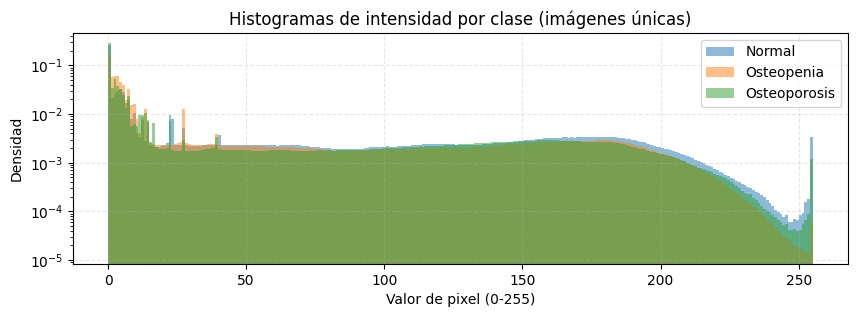

In [ ]:
hist_data = defaultdict(list)

# Agrupo los arrays de píxeles por clase desde las imágenes únicas
for clase, img_path in imagenes_unicas:
    try:
        img = Image.open(img_path).convert('RGB')
        arr = np.array(img).flatten()
        hist_data[clase].append(arr)
    except Exception as e:
        print(f"Error al procesar {img_path}: {e}")

# Concatena por clase
for clase in hist_data:
    hist_data[clase] = np.concatenate(hist_data[clase])

# Graficar
plt.figure(figsize=(10, 3))
for clase, datos in hist_data.items():
    plt.hist(datos, bins=256, range=(0, 255), alpha=0.5, label=clase, density=True)

plt.title("Histogramas de intensidad por clase (imágenes únicas)")
plt.xlabel("Valor de pixel (0-255)")
plt.yscale('log')
plt.ylabel("Densidad")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

A partir de los histogramas, se puede ver que existen diferencias en algunas regiones entre las diferentes clases. En particular, hay una diferencia en la zona de baja intensidad (cercanas al negro total). La diferencia en la zona de alta intensidad es muy chica (el eje y está en escala log). Esta información puede llegar a ser útil a la hora de entrenar modelos para predecir.

Ahora analizo la densidad de intensidad de las imágenes por grupo, considerando para cada uno las imágenes originales y las imágenes generadas por medio de *Data augmentation* (grafico esta información en histogramas).

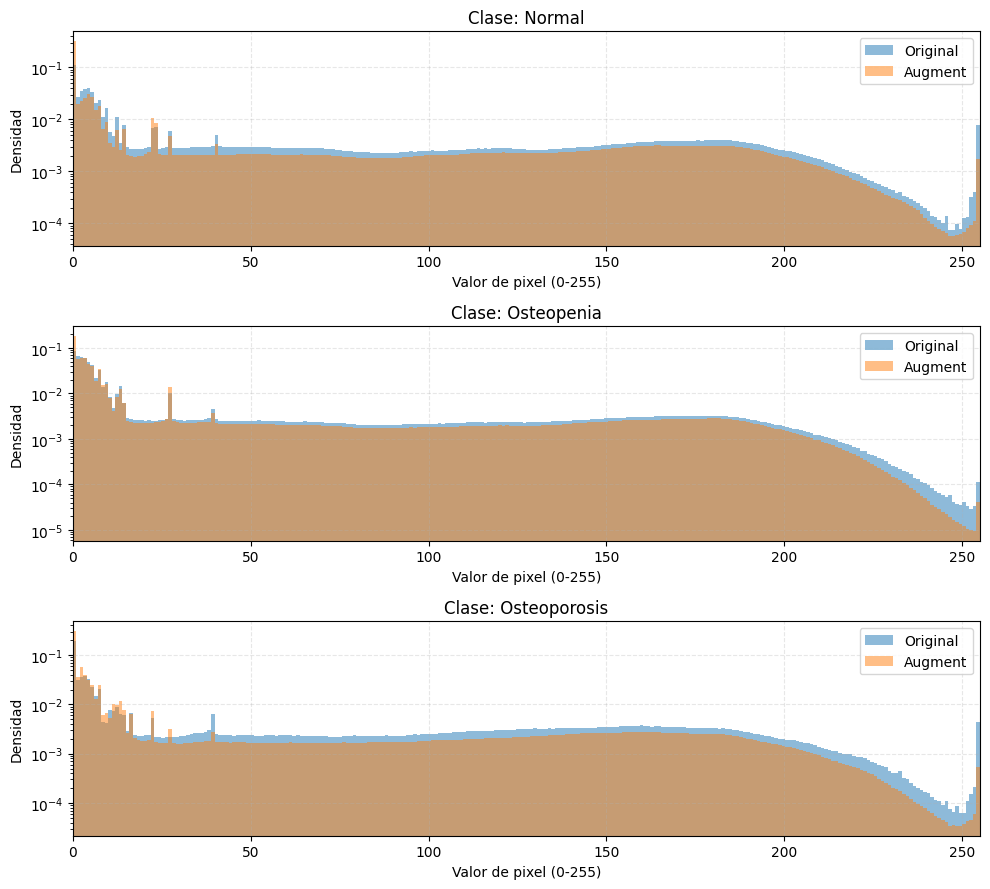

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 9))

for i, clase in enumerate(clases):
    originales = []
    augmentadas = []

    for c, img_path in imagenes_unicas:
        if c != clase:
            continue
        try:
            img = Image.open(img_path).convert('RGB')
            arr = np.array(img).flatten()

            if 'aug' in os.path.basename(img_path).lower():
                augmentadas.append(arr)
            else:
                originales.append(arr)
        except Exception as e:
            print(f"Error al procesar {img_path}: {e}")

    datos_original = np.concatenate(originales) if originales else np.array([])
    datos_aug = np.concatenate(augmentadas) if augmentadas else np.array([])

    if datos_original.size > 0:
        axs[i].hist(datos_original, bins=256, range=(0, 255), alpha=0.5, label='Original', density=True)
    if datos_aug.size > 0:
        axs[i].hist(datos_aug, bins=256, range=(0, 255), alpha=0.5, label='Augment', density=True)

    axs[i].set_title(f"Clase: {clase}")
    axs[i].set_xlim(0, 255)
    axs[i].set_xlabel("Valor de pixel (0-255)")
    axs[i].set_ylabel("Densidad")
    axs[i].legend()
    axs[i].grid(True, linestyle='--', alpha=0.3)
    axs[i].set_yscale('log')

plt.tight_layout()
plt.show()

El *data augmentation*, en particular la rotación, introduce píxeles negros en las esquinas y puede eliminar regiones con información (píxeles con valores de luminosidad mayores a cero) de las imágenes originales. Por este motivo, se observan diferencias en los histogramas de intensidad entre las imágenes con *data augmentation* y las originales.

La clase con más imágenes con *data augmentation* es **Osteoporosis** (907), seguida de **Osteopenia** (885) y **Normal** (824). Esta diferencia en cantidad y contenido podría influir en el comportamiento del modelo durante el entrenamiento.

## Observaciones

A partir del Exploratory Data Analysis (EDA) realizado, se puede decir:

- **Clases balanceadas**: cada clase tiene la misma cantidad de imágenes.
- **Dimensiones uniformes**: todas las imágenes son de 224x224 píxeles.
- **Formato consistente**: todas las imágenes están en escala de grises.
- **Estadísticas**: las medias y desviaciones estándar de intensidad se solapan entre clases, por lo que no ofrecen información discriminativa clara.
- **Distribución de intensidades**: los histogramas por clase muestran diferencias leves en la distribución de píxeles, lo cual podría ser aprovechado por el modelo durante el entrenamiento.
- **Data augmentation**: se aplican transformaciones de rotación, flips horizontales, escalado y deformaciones (shear). Esto permite que el modelo aprenda a generalizar mejor frente a imágenes nuevas que no vio durante el entrenamiento.

# Preparación de datos para el entrenamiento

Ahora genero los tensores para poder entrenar los modelos. Hago una estandarización de los datos, considerando promedio y desvio estandar de todas las imágenes filtradas.

In [ ]:
pixeles = []

for clase, ruta in imagenes_unicas:
    img = Image.open(ruta).convert('RGB')
    arr = np.array(img).astype(np.float32) / 255.0
    pixeles.append(arr.flatten())

pixeles = np.concatenate(pixeles)
mean = pixeles.mean()
std = pixeles.std()

print(f"Media global (únicas): {mean:.4f}")
print(f"Desvío estándar global (únicas): {std:.4f}")

Media global (únicas): 0.2210
Desvío estándar global (únicas): 0.2755


In [ ]:
import torch
# Transformación global (la misma para train, val y test)
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[mean], std=[std])
])

clase_to_idx = {c: i for i, c in enumerate(clases)}

def procesar_y_guardar_conjunto(nombre_subcarpeta, nombre_archivo_salida, usar_imagenes_unicas=False):
    datos = []
    etiquetas = []

    if usar_imagenes_unicas and nombre_subcarpeta == 'train':
        for clase, img_path in imagenes_unicas:
            img = Image.open(img_path).convert('RGB')
            tensor = transform(img)
            datos.append(tensor)
            etiquetas.append(clase_to_idx[clase])
    else:
        for clase in clases:
            carpeta = f"{path}/Knee Osteoarthritis Classification/{nombre_subcarpeta}/{clase}"
            for nombre in os.listdir(carpeta):
                img = Image.open(f"{carpeta}/{nombre}").convert('RGB')
                tensor = transform(img)
                datos.append(tensor)
                etiquetas.append(clase_to_idx[clase])

    X = torch.stack(datos)
    y = torch.tensor(etiquetas)
    torch.save((X, y), nombre_archivo_salida)
    print(f"{nombre_archivo_salida} guardado: {X.shape[0]} imágenes")

procesar_y_guardar_conjunto('train', 'train_normalizado.pt', usar_imagenes_unicas=True)
procesar_y_guardar_conjunto('val', 'val_normalizado.pt')
procesar_y_guardar_conjunto('test', 'test_normalizado.pt')

train_normalizado.pt guardado: 3330 imágenes
val_normalizado.pt guardado: 1080 imágenes
test_normalizado.pt guardado: 540 imágenes


El modelo puede entrenarse a partir de los archivos **.pt** generados.